In [1]:
!nvidia-smi

Fri May 31 15:46:44 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   57C    P0   323W / 400W |  12232MiB / 40960MiB |     99%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [2]:
import torch


# Function to list available GPUs and select one
def select_device():
    if torch.cuda.is_available():
        print("Available GPUs:")
        for i in range(torch.cuda.device_count()):
            print(f"{i}: {torch.cuda.get_device_name(i)}")
        device_id = int(input("Select GPU by entering the device ID (default 0): ") or 0)
        if device_id < torch.cuda.device_count():
            print(f"Using GPU: {torch.cuda.get_device_name(device_id)}")
            return torch.device(f"cuda:{device_id}")
        else:
            print(f"Invalid device ID. Using GPU: {torch.cuda.get_device_name(0)}")
            return torch.device("cuda:0")
    else:
        print("No GPU available. Using CPU.")
        return torch.device("cpu")

# Select the device
device = select_device()

Available GPUs:
0: NVIDIA A100-SXM4-40GB
1: NVIDIA A100-SXM4-40GB
2: NVIDIA A100-SXM4-40GB
3: NVIDIA A100-SXM4-40GB
4: NVIDIA A100-SXM4-40GB
5: NVIDIA A100-SXM4-40GB
6: NVIDIA A100-SXM4-40GB
7: NVIDIA A100-SXM4-40GB
Select GPU by entering the device ID (default 0): 3
Using GPU: NVIDIA A100-SXM4-40GB


In [3]:
import os
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizer

# Function to load the model
def load_model(snapshot_path, model_name="albert-xlarge-v2", num_labels=3):
    model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    model.load_state_dict(torch.load(snapshot_path, map_location=device))
    model.to(device)
    return model

# Function to list all model snapshot files in a directory that match the naming pattern
def list_snapshot_files(snapshot_directory):
    return [os.path.join(snapshot_directory, file_name) for file_name in os.listdir(snapshot_directory) 
            if file_name.startswith('albert_xlarge_anli3_cycle_') and file_name.endswith('.pth')]

# Load all models
snapshot_directory = '/storage/data/st1070263'
snapshot_files = list_snapshot_files(snapshot_directory)
model_snapshots = [load_model(snapshot) for snapshot in snapshot_files]

/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-xlarge-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-xlarge-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-xlarge-v2 and are newly initialized: ['classifier.bi

In [4]:
import pandas as pd

# Path to the test data and loading it
test_data_path = 'ANLI/test_r3.csv'
df_anli_test = pd.read_csv(test_data_path)

# Including 'reason' column in the contextual input
df_anli_test['contextual_input'] = df_anli_test['premise'] + " [SEP] " + df_anli_test['hypothesis'] + " [SEP] " + df_anli_test['reason']
df_anli_test.dropna(subset=['contextual_input', 'label'], inplace=True)
df_anli_test['label'] = df_anli_test['label'].astype(int)

In [5]:
from transformers import AlbertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch

# Assuming the tokenizer has already been defined elsewhere in your notebook
# If not, reinitialize it here
tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")


class ANLITestDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def tokenize_data_with_reason(df, tokenizer):
    return tokenizer(df['contextual_input'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")


# Prepare the test dataset
encodings_with_reason = tokenize_data_with_reason(df_anli_test, tokenizer)
anli_test_dataset_with_reason = ANLITestDataset(encodings_with_reason, df_anli_test['label'].tolist())
anli_test_loader_with_reason = DataLoader(anli_test_dataset_with_reason, batch_size=32, shuffle=False)


In [6]:
from tqdm import tqdm
import torch

# Evaluate model and get predictions with reason
def get_model_predictions_with_reason(model, loader):
    model.eval()
    all_probs = []
    for batch in tqdm(loader, desc="Evaluating", leave=False):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            all_probs.append(probabilities.detach())
    torch.cuda.empty_cache()
    return torch.cat(all_probs, dim=0)

model_probs_with_reason = {}
for i, model in enumerate(model_snapshots):
    print(f"Processing Model {i+1} with reason")
    probabilities_with_reason = get_model_predictions_with_reason(model, anli_test_loader_with_reason)
    model_probs_with_reason[f'model_{i+1}_probs'] = probabilities_with_reason.cpu().numpy()


Processing Model 1 with reason


Evaluating:   0%|                                        | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_490009/1424083206.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Processing Model 2 with reason


Processing Model 3 with reason


Processing Model 4 with reason


Processing Model 5 with reason


In [7]:
import pandas as pd


# Load the data for predictions that include the reason column
model_prob_df = pd.DataFrame()
for key, probs in model_probs_with_reason.items():
    df_probs = pd.DataFrame(probs, columns=[f'{key}_class_0', f'{key}_class_1', f'{key}_class_2'])
    model_prob_df = pd.concat([model_prob_df, df_probs], axis=1)

# Save the DataFrame to a CSV file
model_prob_df.to_csv('model_probabilities_with_reason.csv', index=False)
print("Model predictions stored in 'model_probabilities_with_reason.csv'")


Model predictions stored in 'model_probabilities_with_reason.csv'


In [8]:
model_prob_df

,model_1_probs_class_0,model_1_probs_class_1,model_1_probs_class_2,model_2_probs_class_0,model_2_probs_class_1,model_2_probs_class_2,model_3_probs_class_0,model_3_probs_class_1,model_3_probs_class_2,model_4_probs_class_0,model_4_probs_class_1,model_4_probs_class_2,model_5_probs_class_0,model_5_probs_class_1,model_5_probs_class_2
0,0.286529,0.393186,0.320285,0.335578,0.409444,0.254978,0.343388,0.365736,0.290875,0.364049,0.386564,0.249387,0.365983,0.363246,0.270771
1,0.286552,0.393175,0.320273,0.337678,0.414379,0.247943,0.343383,0.365528,0.291089,0.364049,0.386564,0.249387,0.364883,0.362360,0.272758
2,0.286547,0.393169,0.320284,0.348642,0.393757,0.257601,0.343381,0.365681,0.290938,0.364049,0.386564,0.249387,0.377736,0.352427,0.269837
3,0.286515,0.393190,0.320295,0.344871,0.403499,0.251629,0.343382,0.365688,0.290930,0.364049,0.386564,0.249387,0.375843,0.361902,0.262255
4,0.286551,0.393168,0.320280,0.368429,0.394010,0.237561,0.343388,0.365711,0.290901,0.364049,0.386564,0.249387,0.382451,0.352901,0.264649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.286552,0.393171,0.320277,0.312958,0.424642,0.262400,0.343392,0.365737,0.290871,0.364049,0.386564,0.249387,0.331397,0.390550,0.278053
1196,0.286546,0.393182,0.320272,0.330759,0.426111,0.243130,0.343384,0.365499,0.291118,0.364049,0.386564,0.249387,0.354077,0.371082,0.274841
1197,0.286543,0.393172,0.320285,0.313707,0.430126,0.256167,0.343388,0.365662,0.290950,0.364049,0.386564,0.249387,0.334617,0.387545,0.277838
1198,0.286511,0.393194,0.320295,0.316464,0.471636,0.211900,0.343487,0.366048,0.290465,0.364049,0.386564,0.249387,0.332571,0.391796,0.275633


In [9]:
# Add the true labels to the model probabilities DataFrame
model_prob_df['True_labels'] = df_anli_test['label'].values

In [10]:
model_prob_df

,model_1_probs_class_0,model_1_probs_class_1,model_1_probs_class_2,model_2_probs_class_0,model_2_probs_class_1,model_2_probs_class_2,model_3_probs_class_0,model_3_probs_class_1,model_3_probs_class_2,model_4_probs_class_0,model_4_probs_class_1,model_4_probs_class_2,model_5_probs_class_0,model_5_probs_class_1,model_5_probs_class_2,True_labels
0,0.286529,0.393186,0.320285,0.335578,0.409444,0.254978,0.343388,0.365736,0.290875,0.364049,0.386564,0.249387,0.365983,0.363246,0.270771,0
1,0.286552,0.393175,0.320273,0.337678,0.414379,0.247943,0.343383,0.365528,0.291089,0.364049,0.386564,0.249387,0.364883,0.362360,0.272758,0
2,0.286547,0.393169,0.320284,0.348642,0.393757,0.257601,0.343381,0.365681,0.290938,0.364049,0.386564,0.249387,0.377736,0.352427,0.269837,0
3,0.286515,0.393190,0.320295,0.344871,0.403499,0.251629,0.343382,0.365688,0.290930,0.364049,0.386564,0.249387,0.375843,0.361902,0.262255,0
4,0.286551,0.393168,0.320280,0.368429,0.394010,0.237561,0.343388,0.365711,0.290901,0.364049,0.386564,0.249387,0.382451,0.352901,0.264649,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.286552,0.393171,0.320277,0.312958,0.424642,0.262400,0.343392,0.365737,0.290871,0.364049,0.386564,0.249387,0.331397,0.390550,0.278053,2
1196,0.286546,0.393182,0.320272,0.330759,0.426111,0.243130,0.343384,0.365499,0.291118,0.364049,0.386564,0.249387,0.354077,0.371082,0.274841,2
1197,0.286543,0.393172,0.320285,0.313707,0.430126,0.256167,0.343388,0.365662,0.290950,0.364049,0.386564,0.249387,0.334617,0.387545,0.277838,2
1198,0.286511,0.393194,0.320295,0.316464,0.471636,0.211900,0.343487,0.366048,0.290465,0.364049,0.386564,0.249387,0.332571,0.391796,0.275633,2


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# Step 1: Calculate Individual Model Accuracy
def calculate_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

n_models = len(model_snapshots)  # Adjust the number of models based on your ensemble
accuracy_per_model = {}
for i in range(1, n_models + 1):
    probs = model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    accuracy_per_model[f'model_{i}'] = calculate_accuracy(probs, model_prob_df['True_labels'].values)

# Step 2: Calculate Correlations Between Model Predictions
correlation_matrix = np.zeros((n_models, n_models))
for i in range(1, n_models + 1):
    for j in range(1, n_models + 1):
        true_class_probs_i = model_prob_df[[f'model_{i}_probs_class_{k}' for k in model_prob_df['True_labels']]].values
        true_class_probs_j = model_prob_df[[f'model_{j}_probs_class_{k}' for k in model_prob_df['True_labels']]].values
        correlation_matrix[i-1, j-1] = np.corrcoef(true_class_probs_i.ravel(), true_class_probs_j.ravel())[0, 1]

# Display results
print("Accuracy per model:", accuracy_per_model)
print("Correlation matrix between model predictions:\n", correlation_matrix)

Accuracy per model: {'model_1': 0.335, 'model_2': 0.3358333333333333, 'model_3': 0.335, 'model_4': 0.335, 'model_5': 0.34}
Correlation matrix between model predictions:
 [[1.         0.66543469 0.48275699 0.35446894 0.38781062]
 [0.66543469 1.         0.91608519 0.87037256 0.90360429]
 [0.48275699 0.91608519 1.         0.99000312 0.95080901]
 [0.35446894 0.87037256 0.99000312 1.         0.952646  ]
 [0.38781062 0.90360429 0.95080901 0.952646   1.        ]]


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, title):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.5)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



Accuracy of the averaged model: 0.335
Categorical Cross-Entropy Loss of the averaged model: 1.1086016303797563


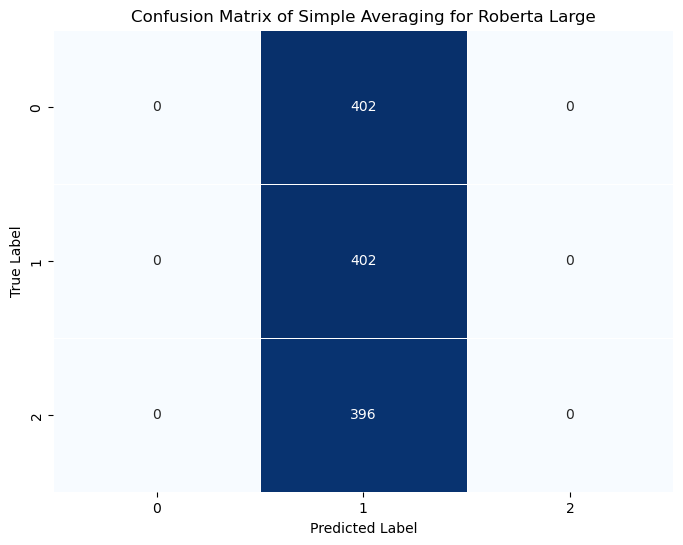

In [13]:
# Compute the average probabilities across all models
average_probs = np.mean([
    model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    for i in range(1, n_models + 1)
], axis=0)

# Determine predicted labels from the average probabilities
predicted_labels_from_average = np.argmax(average_probs, axis=1)

# Calculate accuracy of the averaged model
average_model_accuracy = np.mean(predicted_labels_from_average == model_prob_df['True_labels'].values)

print("Accuracy of the averaged model:", average_model_accuracy)

import numpy as np

def one_hot_encode(labels, num_classes):
    """ Convert array of labels to one-hot encoded numpy array. """
    return np.eye(num_classes)[labels]

def categorical_cross_entropy(true_labels, predicted_probs):
    """ Compute the categorical cross-entropy loss. """
    true_labels_one_hot = one_hot_encode(true_labels, num_classes=predicted_probs.shape[1])
    log_probs = np.log(predicted_probs + 1e-15)  # Adding a small epsilon to avoid log(0)
    loss = -np.sum(true_labels_one_hot * log_probs) / true_labels_one_hot.shape[0]
    return loss

# Assuming 'average_probs' is already calculated as suggested in the previous step
true_labels = model_prob_df['True_labels'].values
loss = categorical_cross_entropy(true_labels, average_probs)

print("Categorical Cross-Entropy Loss of the averaged model:", loss)

# Plotting the confusion matrix for the Simple Averaging method
plot_confusion_matrix(true_labels, predicted_labels_from_average, 'Confusion Matrix of Simple Averaging for Roberta Large')


Accuracy of the majority vote: 0.335
Adjusted Categorical Cross-Entropy Loss for the majority vote: 2.73409615368901


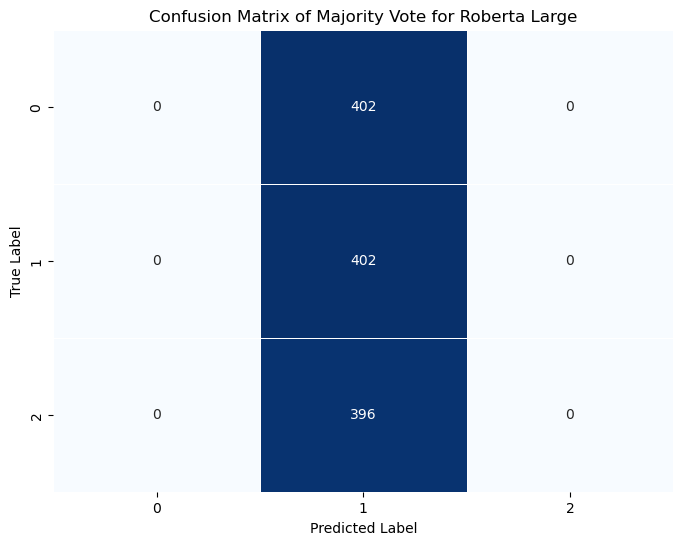

In [14]:
import numpy as np

# Assuming you have a DataFrame called 'model_prob_df' which includes the predicted probabilities for each class
# from each model and it looks something like this:
# Columns: ['model_1_probs_class_0', 'model_1_probs_class_1', 'model_1_probs_class_2', ..., 'model_5_probs_class_0', 'model_5_probs_class_1', 'model_5_probs_class_2', 'True_labels']

# Extract predicted labels for each model
predicted_labels = {}
n_models = 5  # Adjust the number of models based on your ensemble
for i in range(1, n_models + 1):
    probs = model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    predicted_labels[f'model_{i}'] = np.argmax(probs, axis=1)

# Constructing an array of all predictions
all_predictions = np.vstack([predicted_labels[f'model_{i}'] for i in range(1, n_models + 1)])

# Majority vote calculation
majority_vote = np.apply_along_axis(lambda x: np.bincount(x, minlength=3).argmax(), 0, all_predictions)

# Calculate the accuracy of the majority vote
true_labels = model_prob_df['True_labels'].values
majority_vote_accuracy = np.mean(majority_vote == true_labels)

print("Accuracy of the majority vote:", majority_vote_accuracy)
# Assuming majority_vote contains the predicted labels from your majority vote procedure
num_classes = 3  # Set this to the number of classes in your dataset
majority_vote_probs = one_hot_encode(majority_vote, num_classes)

def smooth_one_hot(true_labels, num_classes, smoothing=0.1):
    """
    Apply label smoothing. Default epsilon is 0.1.
    This helps to mitigate the issue with hard zero probabilities leading to infinite loss.
    """
    # Create an array where all elements are equal to a small value (smoothing / num_classes)
    confidence = 1.0 - smoothing
    smooth_prob = smoothing / num_classes
    one_hot_labels = np.eye(num_classes)[true_labels]
    return one_hot_labels * confidence + smooth_prob

# Calculate the smoothed probabilities for the majority vote predictions
majority_vote_smooth_probs = smooth_one_hot(majority_vote, num_classes, smoothing=0.05)  # Smoothing with a small epsilon value

# Calculate loss with the smoothed probabilities
loss = categorical_cross_entropy(true_labels, majority_vote_smooth_probs)

print("Adjusted Categorical Cross-Entropy Loss for the majority vote:", loss)


# Plotting the confusion matrix for the Majority Vote method
plot_confusion_matrix(true_labels, majority_vote, 'Confusion Matrix of Majority Vote for Roberta Large')
